# Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Check GPU
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(1))

2
NVIDIA GeForce RTX 3090


# Part C 

## Implement Custom Resnet + Group Normalization

In [2]:
class CustomResNet_GN(nn.Module):
    def __init__(self, groups=32):
        super(CustomResNet_GN, self).__init__()

        # Initial layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.norm1 = nn.GroupNorm(groups, 32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.norm2 = nn.GroupNorm(groups, 64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Residual block 1
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.norm3 = nn.GroupNorm(groups, 64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.norm4 = nn.GroupNorm(groups, 64)
        self.match_conv1 = nn.Conv2d(64, 64, kernel_size=1, stride=1, padding=0)

        # Residual block 2
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.norm5 = nn.GroupNorm(groups, 128)
        self.match_conv2 = nn.Conv2d(64, 128, kernel_size=1, stride=2, padding=0)

        # Residual block 3
        self.conv6 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.norm6 = nn.GroupNorm(groups, 256)
        self.conv7 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.norm7 = nn.GroupNorm(groups, 256)
        self.match_conv3 = nn.Conv2d(128, 256, kernel_size=1, stride=2, padding=0)

        # Final layers
        self.avg_pool = nn.AvgPool2d(kernel_size=3)
        self.fc1 = nn.Linear(256, 256)
        self.norm8 = nn.GroupNorm(groups, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.elu(self.norm1(self.conv1(x)))
        x = F.elu(self.norm2(self.conv2(x)))
        x = self.pool1(x)

        # Residual block 1
        identity = x
        x = F.elu(self.norm3(self.conv3(x)))
        x = F.elu(self.norm4(self.conv4(x)))
        x += identity
        x = F.elu(x)

        # Residual block 2
        identity = self.match_conv2(x)  
        x = F.elu(self.norm5(self.conv5(x)))
        x = self.pool1(x)  # Use pool1 instead of pool2
        x += identity
        x = F.elu(x)

        # Residual block 3
        identity = self.match_conv3(x)  
        x = F.elu(self.norm6(self.conv6(x)))
        x = self.pool1(x)  # Use pool1 instead of pool3
        x = F.elu(self.norm7(self.conv7(x)))
        x += identity
        x = F.elu(x)

        # Final layers
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = F.elu(self.norm8(self.fc1(x)))
        x = self.fc2(x)

        return x


## Load Dataset

In [3]:
# Data augmentation and normalization
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# # Data augmentation and normalization for training
# transform_train = transforms.Compose([
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(15),
#     transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
#     transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
#     transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [4]:
# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Splitting train dataset into train and validation sets
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


## Optimizer and Train Setup

In [5]:
# Model, optimizer, and scheduler
model = CustomResNet_GN()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=40, gamma=0.1)
criterion = nn.CrossEntropyLoss()

In [6]:
# Determine if CUDA is available and set the device accordingly
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model.to(device)

CustomResNet_GN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm1): GroupNorm(32, 32, eps=1e-05, affine=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm3): GroupNorm(32, 64, eps=1e-05, affine=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm4): GroupNorm(32, 64, eps=1e-05, affine=True)
  (match_conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm5): GroupNorm(32, 128, eps=1e-05, affine=True)
  (match_conv2): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))
  (conv6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm6): GroupNorm(32, 256, ep

In [7]:
def train(model, device, train_loader, optimizer, criterion):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    train_loss /= len(train_loader)
    train_accuracy = 100 * correct / total
    return train_loss, train_accuracy

def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item()
            _, predicted = output.max(1)
            correct += predicted.eq(target).sum().item()

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

# Training loop with tracking of training and validation accuracies
train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []
best_val_accuracy = 0
best_model_weights = None


In [8]:
for epoch in range(1, 61):
    train_loss, train_accuracy = train(model, device, train_loader, optimizer , criterion)
    val_loss, val_accuracy = test(model, device, val_loader , criterion)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model_weights = model.state_dict()

    print(f'Epoch: {epoch}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')
    scheduler.step()

Epoch: 1, Train Loss: 1.7443, Train Accuracy: 36.58%, Val Loss: 1.4263, Val Accuracy: 48.58%
Epoch: 2, Train Loss: 1.2404, Train Accuracy: 55.66%, Val Loss: 1.1197, Val Accuracy: 59.48%
Epoch: 3, Train Loss: 1.0226, Train Accuracy: 64.02%, Val Loss: 0.9931, Val Accuracy: 63.48%
Epoch: 4, Train Loss: 0.8879, Train Accuracy: 68.62%, Val Loss: 0.8629, Val Accuracy: 69.66%
Epoch: 5, Train Loss: 0.7969, Train Accuracy: 72.16%, Val Loss: 0.7592, Val Accuracy: 73.62%
Epoch: 6, Train Loss: 0.7269, Train Accuracy: 74.69%, Val Loss: 0.7361, Val Accuracy: 73.94%
Epoch: 7, Train Loss: 0.6727, Train Accuracy: 76.35%, Val Loss: 0.6974, Val Accuracy: 76.30%
Epoch: 8, Train Loss: 0.6249, Train Accuracy: 78.21%, Val Loss: 0.6528, Val Accuracy: 77.66%
Epoch: 9, Train Loss: 0.5916, Train Accuracy: 79.31%, Val Loss: 0.6293, Val Accuracy: 77.94%
Epoch: 10, Train Loss: 0.5582, Train Accuracy: 80.49%, Val Loss: 0.6247, Val Accuracy: 78.58%
Epoch: 11, Train Loss: 0.5275, Train Accuracy: 81.55%, Val Loss: 0.65

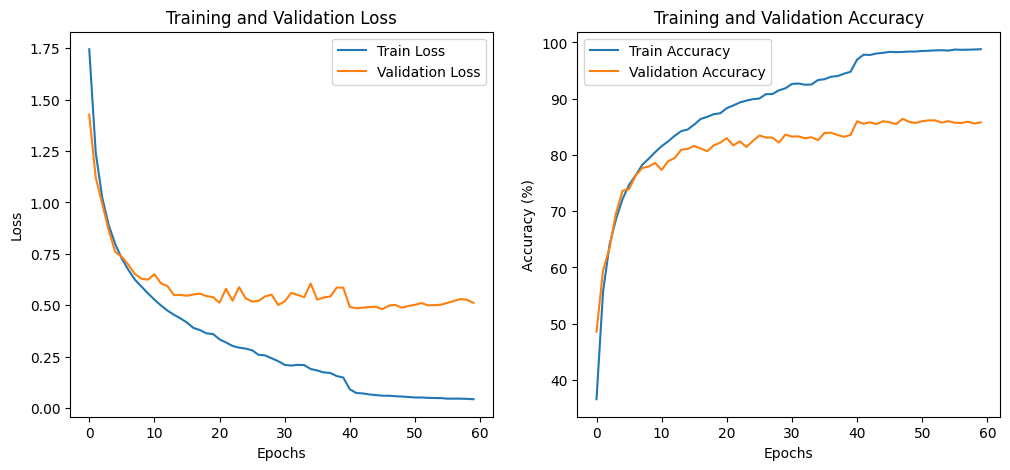

Best Validation Accuracy: 86.42%
Test Accuracy of the final model: 87.37%


In [9]:
# Load best model weights and evaluate on test set
model.load_state_dict(best_model_weights)
test_loss, test_accuracy = test(model, device, test_loader , criterion)

# Plotting training and validation loss and accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

# Print best validation accuracy and test accuracy
print(f'Best Validation Accuracy: {best_val_accuracy:.2f}%')
print(f'Test Accuracy of the final model: {test_accuracy:.2f}%')

# Save best model weights
torch.save(best_model_weights, 'best_custom_resnet_weights_GN.pth')

# Layer Wise analyse , Part A

In [ ]:
# download Pretrained Weight of model
import gdown
id = "1Du8QY70d90wIPvrLip_Q3trsyeLvdE9L"
gdown.download(id=id, quiet=False)

In [ ]:
!git clone https://github.com/Arhosseini77/data_complexity_measures

In [2]:
from data_complexity_measures.models.ARH_SeparationIndex import ARH_SeparationIndex

In [3]:
class CustomResNet_GN(nn.Module):
    def __init__(self, groups=32):
        super(CustomResNet_GN, self).__init__()

        # Initial layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.norm1 = nn.GroupNorm(groups, 32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.norm2 = nn.GroupNorm(groups, 64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Residual block 1
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.norm3 = nn.GroupNorm(groups, 64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.norm4 = nn.GroupNorm(groups, 64)
        self.match_conv1 = nn.Conv2d(64, 64, kernel_size=1, stride=1, padding=0)

        # Residual block 2
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.norm5 = nn.GroupNorm(groups, 128)
        self.match_conv2 = nn.Conv2d(64, 128, kernel_size=1, stride=2, padding=0)

        # Residual block 3
        self.conv6 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.norm6 = nn.GroupNorm(groups, 256)
        self.conv7 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.norm7 = nn.GroupNorm(groups, 256)
        self.match_conv3 = nn.Conv2d(128, 256, kernel_size=1, stride=2, padding=0)

        # Final layers
        self.avg_pool = nn.AvgPool2d(kernel_size=3)
        self.fc1 = nn.Linear(256, 256)
        self.norm8 = nn.GroupNorm(groups, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.elu(self.norm1(self.conv1(x)))
        x = F.elu(self.norm2(self.conv2(x)))
        x = self.pool1(x)

        # Residual block 1
        identity = x
        x = F.elu(self.norm3(self.conv3(x)))
        x = F.elu(self.norm4(self.conv4(x)))
        x += identity
        x = F.elu(x)

        # Residual block 2
        identity = self.match_conv2(x)  
        x = F.elu(self.norm5(self.conv5(x)))
        x = self.pool1(x)  # Use pool1 instead of pool2
        x += identity
        x = F.elu(x)

        # Residual block 3
        identity = self.match_conv3(x)  
        x = F.elu(self.norm6(self.conv6(x)))
        x = self.pool1(x)  # Use pool1 instead of pool3
        x = F.elu(self.norm7(self.conv7(x)))
        x += identity
        x = F.elu(x)

        # Final layers
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = F.elu(self.norm8(self.fc1(x)))
        x = self.fc2(x)

        return x


In [4]:
# Data augmentation and normalization
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [5]:
# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Splitting train dataset into train and validation sets
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])


# Further split train_dataset into train_loader_dataset and 20% balanced subset
train_loader_dataset, _ = train_test_split(train_dataset.dataset, train_size=int(0.2 * len(train_dataset)),
                                           test_size=None, shuffle=True, stratify=train_dataset.dataset.targets)

# Data loaders
train_loader = DataLoader(train_loader_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# Instantiate and load the model
model = CustomResNet_GN()  # Make sure CustomResNet is defined as earlier
model.load_state_dict(torch.load('best_custom_resnet_weights_GN.pth'))
model.to('cuda:1' if torch.cuda.is_available() else 'cpu')
model.eval()

CustomResNet_GN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm1): GroupNorm(32, 32, eps=1e-05, affine=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm3): GroupNorm(32, 64, eps=1e-05, affine=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm4): GroupNorm(32, 64, eps=1e-05, affine=True)
  (match_conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm5): GroupNorm(32, 128, eps=1e-05, affine=True)
  (match_conv2): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))
  (conv6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm6): GroupNorm(32, 256, ep

In [7]:
# Prepare storage for outputs and labels
features_per_layer = {}
labels_list = []

# Define layers to exclude
exclude_layers = {'match_conv1', 'match_conv2', 'match_conv3', 'fc1', 'fc2'}

# Function to attach hooks
def get_layer_outputs(layer_name):
    def hook(module, input, output):
        features_per_layer[layer_name].append(output.detach())
    return hook

# Attach hooks to each layer except the excluded ones
for name, layer in model.named_children():
    if name not in exclude_layers:
        features_per_layer[name] = []
        layer.register_forward_hook(get_layer_outputs(name))

## SI and CenterSI layer for Train Loader

In [8]:
# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(train_loader): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        print(layer_name)
        print(len(features_per_layer[layer_name]))

        # Flatten and concatenate, handling pooling layers
        if 'pool' in layer_name:
            # Calculate the expected size based on the pooling operation
            pool_size = layer_features[0].size(2) // layer_features[1].size(2)
            features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1)[:,:256] for f in layer_features], dim=1)
        else:
            features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])

    else:
        print(f"No features captured for layer {layer_name}")

# Concatenate the labels
labels = torch.cat(labels_list)

100%|██████████| 36/36 [00:00<00:00, 64.48it/s]


conv1
36
norm1
36
conv2
36
norm2
36
pool1
108


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 256 but got size 40 for tensor number 105 in the list.

### Calc SI

In [19]:
si_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    si = instance_disturbance.si_batch(batch_size=2000)
    si_layer_train.append((layer_name, si))

Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 369.36it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7264.12it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 6964.97it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 6452.78it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7413.05it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7325.02it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 6914.45it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7639.90it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7348.11it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 6944.21it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7570.95it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7169.75it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7322.46it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7169.75it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 6680.96it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7264.12it/s]

Data has been normalized



Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7698.80it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7244.05it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7056.37it/s]


In [20]:
si_layer_train

[('conv1', 0.2504444420337677),
 ('bn1', 0.2504444420337677),
 ('conv2', 0.24211111664772034),
 ('bn2', 0.24211111664772034),
 ('pool1', 0.31700000166893005),
 ('conv3', 0.4112222194671631),
 ('bn3', 0.4112222194671631),
 ('conv4', 0.4717777967453003),
 ('bn4', 0.4717777967453003),
 ('conv5', 0.39988890290260315),
 ('bn5', 0.39988890290260315),
 ('pool2', 0.41233333945274353),
 ('conv6', 0.5109999775886536),
 ('bn6', 0.5109999775886536),
 ('pool3', 0.5292222499847412),
 ('conv7', 0.6710000038146973),
 ('bn7', 0.6710000038146973),
 ('avg_pool', 0.8182222247123718),
 ('bn8', 0.9514444470405579)]

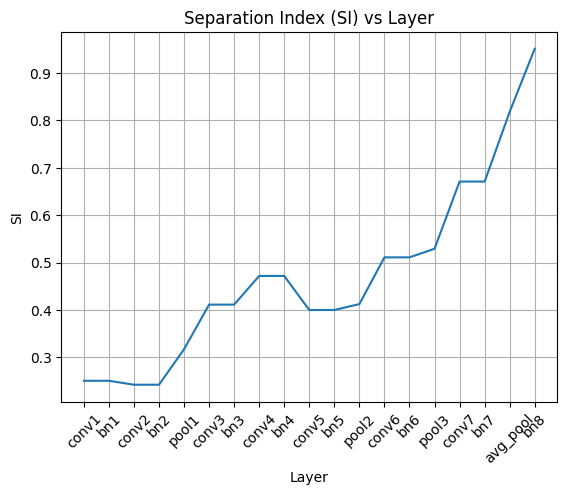

In [21]:
# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in si_layer_train], [si for _, si in si_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Separation Index (SI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### Calc Center Si

In [22]:
csi_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_train.append((layer_name, csi))

Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 917.71it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4327.59it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3948.70it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4669.68it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3087.23it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3302.60it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3166.95it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 2821.03it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3172.70it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4249.55it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4337.44it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4034.54it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3252.91it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3146.04it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3980.17it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4358.17it/s]

Data has been normalized



Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4226.42it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 2707.05it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3354.37it/s]


[('conv1', 0.35011112689971924), ('bn1', 0.35011112689971924), ('conv2', 0.37522223591804504), ('bn2', 0.37522223591804504), ('pool1', 0.4441111087799072), ('conv3', 0.5175555348396301), ('bn3', 0.5175555348396301), ('conv4', 0.5108888745307922), ('bn4', 0.5108888745307922), ('conv5', 0.5517777800559998), ('bn5', 0.5517777800559998), ('pool2', 0.6019999980926514), ('conv6', 0.6213333606719971), ('bn6', 0.6213333606719971), ('pool3', 0.6778888702392578), ('conv7', 0.7039999961853027), ('bn7', 0.7039999961853027), ('avg_pool', 0.8676666617393494), ('bn8', 0.9779999852180481)]


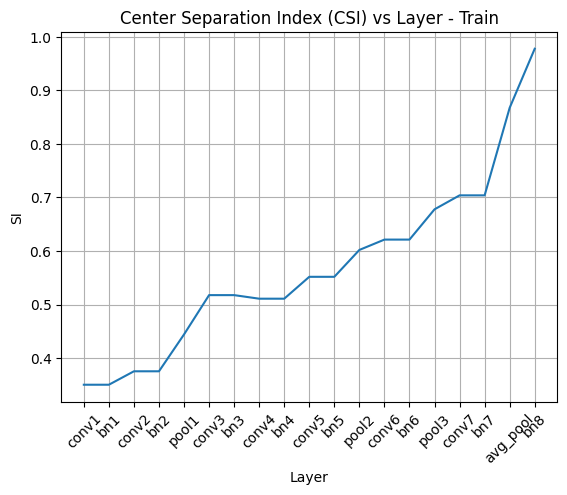

In [23]:
print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train], [si for _, si in csi_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer - Train')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## SI and CenterSI layer for Val Loader

In [8]:
# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(val_loader): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        # Flatten and concatenate the features for each layer
        features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
    else:
        print(f"No features captured for layer {layer_name}")

# Concatenate the labels
labels = torch.cat(labels_list)

100%|██████████| 20/20 [00:00<00:00, 22.72it/s]


### Calc SI

In [9]:
si_layer_val = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    si = instance_disturbance.si_batch(batch_size=2000)
    si_layer_val.append((layer_name, si))

Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 230.43it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 4691.62it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 1463.13it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5156.93it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 4656.89it/s]

Data has been normalized



Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5104.63it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 4955.85it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5017.11it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 4944.17it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5197.40it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 4817.35it/s]

Data has been normalized



Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 4932.54it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 4764.45it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5286.94it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 4878.99it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 4665.52it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5440.08it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 4848.91it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5100.49it/s]


In [10]:
si_layer_val

[('conv1', 0.2149999886751175),
 ('bn1', 0.2149999886751175),
 ('conv2', 0.21679998934268951),
 ('bn2', 0.21679998934268951),
 ('pool1', 0.28439998626708984),
 ('conv3', 0.3885999917984009),
 ('bn3', 0.3885999917984009),
 ('conv4', 0.44179999828338623),
 ('bn4', 0.44179999828338623),
 ('conv5', 0.3755999803543091),
 ('bn5', 0.3755999803543091),
 ('pool2', 0.397599995136261),
 ('conv6', 0.47259998321533203),
 ('bn6', 0.47259998321533203),
 ('pool3', 0.4973999857902527),
 ('conv7', 0.6455999612808228),
 ('bn7', 0.6455999612808228),
 ('avg_pool', 0.8046000003814697),
 ('bn8', 0.9391999840736389)]

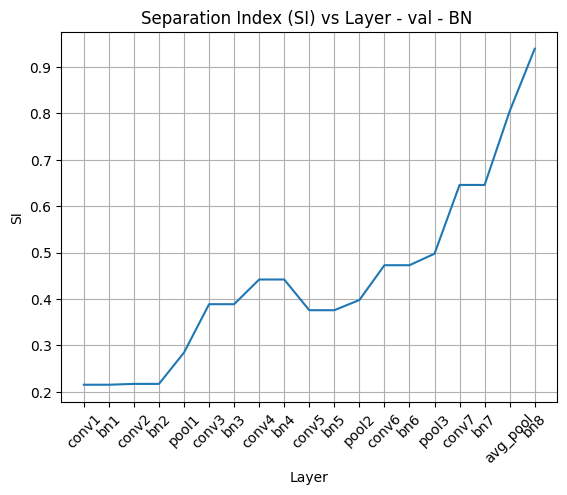

In [11]:
# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in si_layer_val], [si for _, si in si_layer_val])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Separation Index (SI) vs Layer - val - BN ')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### calc Center SI

In [12]:
csi_layer_val = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_val.append((layer_name, csi))

Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 455.79it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3111.50it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3069.00it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3331.46it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2829.53it/s]

Data has been normalized



Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3275.95it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3549.48it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2866.92it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3368.02it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3063.03it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3174.30it/s]

Data has been normalized



Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2922.86it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3268.29it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3282.78it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3038.62it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3119.21it/s]

Data has been normalized



Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3191.20it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 1731.75it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2360.77it/s]


[('conv1', 0.3540000021457672), ('bn1', 0.3540000021457672), ('conv2', 0.38279998302459717), ('bn2', 0.38279998302459717), ('pool1', 0.4585999846458435), ('conv3', 0.5297999978065491), ('bn3', 0.5297999978065491), ('conv4', 0.517799973487854), ('bn4', 0.517799973487854), ('conv5', 0.5577999949455261), ('bn5', 0.5577999949455261), ('pool2', 0.604200005531311), ('conv6', 0.6189999580383301), ('bn6', 0.6189999580383301), ('pool3', 0.6797999739646912), ('conv7', 0.7019999623298645), ('bn7', 0.7019999623298645), ('avg_pool', 0.8711999654769897), ('bn8', 0.9745999574661255)]


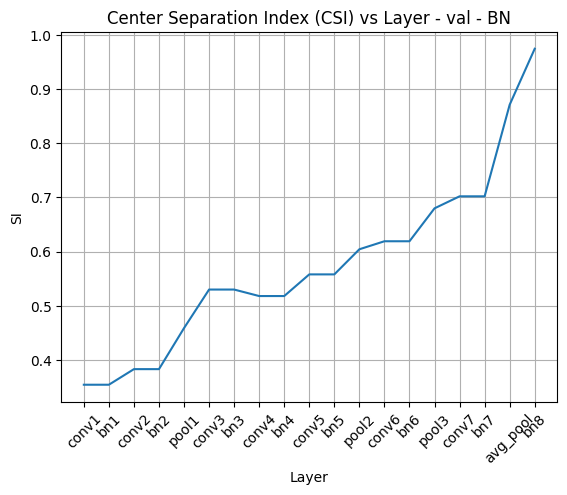

In [13]:
print(csi_layer_val)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_val], [si for _, si in csi_layer_val])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer - val - BN')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## SI and CenterSI layer for Test Loader

In [8]:
# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(test_loader):
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        # Flatten and concatenate the features for each layer
        features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
    else:
        print(f"No features captured for layer {layer_name}")

# Concatenate the labels
labels = torch.cat(labels_list)

100%|██████████| 40/40 [00:01<00:00, 26.92it/s]


### Calc SI

In [9]:
si_layer_test = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    si = instance_disturbance.si_batch(batch_size=2000)
    si_layer_test.append((layer_name, si))

Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 365.45it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7030.35it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7998.29it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7463.17it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7662.23it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7249.06it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7077.80it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7738.57it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7928.74it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7851.56it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7013.89it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 6882.68it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7715.79it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7775.87it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 2774.01it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7581.89it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7967.90it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 6014.20it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7441.99it/s]


In [10]:
si_layer_test

[('conv1', 0.23349998891353607),
 ('bn1', 0.23349998891353607),
 ('conv2', 0.22179999947547913),
 ('bn2', 0.22179999947547913),
 ('pool1', 0.29889997839927673),
 ('conv3', 0.41259998083114624),
 ('bn3', 0.41259998083114624),
 ('conv4', 0.4887999892234802),
 ('bn4', 0.4887999892234802),
 ('conv5', 0.3929999768733978),
 ('bn5', 0.3929999768733978),
 ('pool2', 0.4106999933719635),
 ('conv6', 0.5157999992370605),
 ('bn6', 0.5157999992370605),
 ('pool3', 0.5342000126838684),
 ('conv7', 0.6650999784469604),
 ('bn7', 0.6650999784469604),
 ('avg_pool', 0.7333999872207642),
 ('bn8', 0.7930999994277954)]

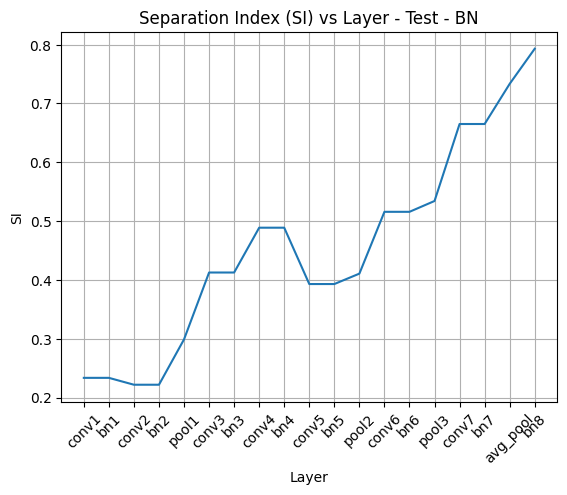

In [11]:
# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in si_layer_test], [si for _, si in si_layer_test])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Separation Index (SI) vs Layer - Test - BN')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### Calc Center SI

In [12]:
csi_layer_test = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_test.append((layer_name, csi))

Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 939.46it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4580.93it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4184.26it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4456.34it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3111.96it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3470.96it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3379.78it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 1665.46it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3139.45it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4435.60it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4466.78it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4156.07it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3260.50it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3152.19it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4198.50it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4451.61it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4445.00it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4343.73it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4570.95it/s]


[('conv1', 0.3529999852180481), ('bn1', 0.3529999852180481), ('conv2', 0.37529999017715454), ('bn2', 0.37529999017715454), ('pool1', 0.44439998269081116), ('conv3', 0.5123000144958496), ('bn3', 0.5123000144958496), ('conv4', 0.5044999718666077), ('bn4', 0.5044999718666077), ('conv5', 0.539900004863739), ('bn5', 0.539900004863739), ('pool2', 0.5845000147819519), ('conv6', 0.6121999621391296), ('bn6', 0.6121999621391296), ('pool3', 0.6599000096321106), ('conv7', 0.6830999851226807), ('bn7', 0.6830999851226807), ('avg_pool', 0.7893999814987183), ('bn8', 0.8560000061988831)]


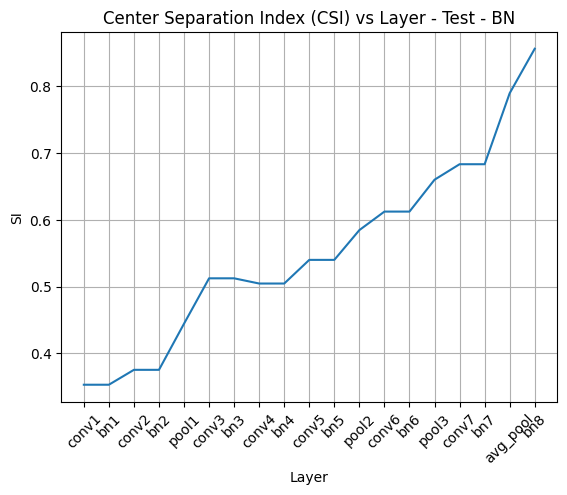

In [13]:
print(csi_layer_test)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_test], [si for _, si in csi_layer_test])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer - Test - BN')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()